In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
#To format output figure sizes
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = base.classes.measurement
stations = base.classes.station

In [9]:
# Create our session (link) from Python to the DB - check class unit 10.1
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
recent_date

('2017-08-23',)

In [11]:
#Finding the oldest date in the dataset
oldest_date = session.query(measurements.date).order_by(measurements.date).first()
oldest_date

('2010-01-01',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcp_recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = prcp_recent_date - dt.timedelta(days=365)

In [13]:
# Perform a query to retrieve the date and precipitation scores
sel = [measurements.date, measurements.prcp]
prcp_data = session.query(*sel).filter(measurements.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation (in)"])

precipitation_df.set_index("Date", inplace=True)

precipitation_df

,Precipitation (in)
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [14]:
# Converting the index as date
precipitation_df.index = pd.to_datetime(precipitation_df.index)

In [15]:
#Verifying NA value counts in DataFrame
precipitation_df.isna().value_counts()

Precipitation (in)
False                 2015
True                   208
dtype: int64

In [16]:
# Sort the dataframe by date & dropping NA values
precipitation_df.sort_values(by="Date").dropna(inplace=True)

In [17]:
#Verifying all NA values are gone
precipitation_df.isna().value_counts()

Precipitation (in)
False                 2015
True                   208
dtype: int64

In [18]:
precipitation_df.dtypes

Precipitation (in)    float64
dtype: object

In [19]:
precipitation_df

,Precipitation (in)
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


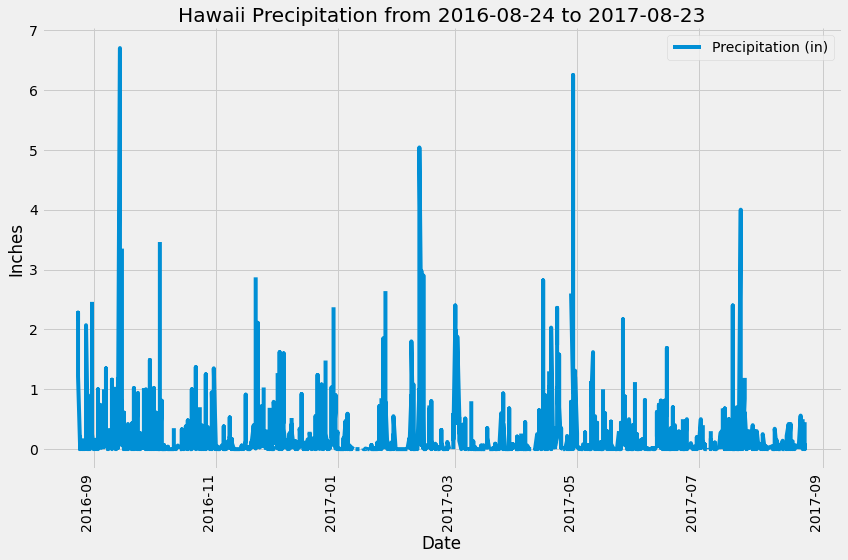

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
precipitation_df.plot(rot=90, title = "Hawaii Precipitation from 2016-08-24 to 2017-08-23", xlabel='Date', ylabel = "Inches")
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.savefig( "Resources/Precipitation_Inches_vs_Date.png", bbox_inches='tight')
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation (in)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(stations).\
                    distinct().\
                    count()

                    
print(f'The total stations are {total_stations}.')

The total stations are 9.


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows/datapoints?)
# List the stations and the counts in descending order. First make sel with desired data
sel = [measurements.station, func.count(measurements.station)]

station_activity = session.query(*sel).\
        group_by(measurements.station).\
        order_by(func.count(measurements.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. (Print MIN, MAX, AVG for USC00519281)
sel = [measurements.station, func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)]

act_station_temps = session.query(*sel).\
        filter(measurements.station == 'USC00519281').\
        group_by(measurements.station).all()

act_station_temps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
sel = [measurements.date, measurements.tobs]

act_station_data = session.query(*sel).\
        filter(measurements.station == 'USC00519281').\
        filter(measurements.date >= one_year_ago).\
        group_by(measurements.date).all()

act_station_df = pd.DataFrame(act_station_data, columns=["Date", "Temperature (F)"])
act_station_df

,Date,Temperature (F)
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


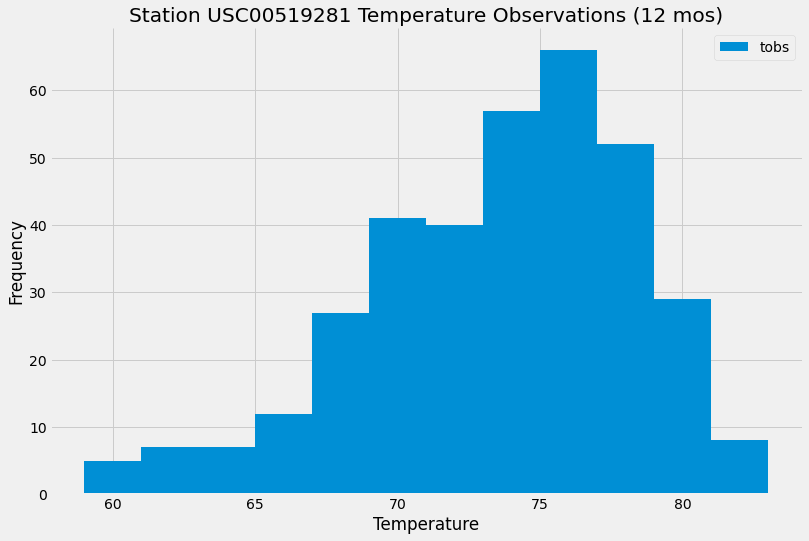

In [33]:
# Plot the 12 month results for the most active station as a histogram
plt.hist(act_station_df['Temperature (F)'], bins=12, label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend()
plt.title("Station USC00519281 Temperature Observations (12 mos)")
plt.figsize=(10,7)
plt.savefig('USC00519281_Histogram.png',bbox_inches='tight')
plt.show()

# Close session

In [34]:
# Close Session
session.close()